In [ ]:
!pip install ultralytics opencv-python-headless matplotlib easyocr

In [ ]:
!pip install pytesseract
!pip install imgaug

In [3]:
import os
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'

In [ ]:
!apt-get install tesseract-ocr
!apt-get install tesseract-ocr-kor


In [5]:
import json
import os
import shutil
import requests
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import pytesseract

In [6]:
model = YOLO('/content/drive/MyDrive/runs/detect/train_v9t_us/weights/best.pt')

# Step 7: Use the trained model to run detection on sample images
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'  # Adjust path as necessary


0: 640x640 1 First_Name, 1 Last_Name, 1 DLNumber, 1 Address, 1 DOB, 1 Sex, 1 Class, 308.0ms
1: 640x640 1 First_Name, 1 Last_Name, 1 DLNumber, 1 Address, 1 DOB, 1 ExpiryDate, 1 IssueDate, 1 Sex, 1 Class, 308.0ms
2: 640x640 1 DLNumber, 1 Address, 1 DOB, 1 ExpiryDate, 1 IssueDate, 1 Sex, 1 Name, 308.0ms
3: 640x640 1 DLNumber, 1 Address, 1 DOB, 1 ExpiryDate, 1 IssueDate, 1 Sex, 1 Class, 1 Name, 308.0ms
Speed: 6.3ms preprocess, 308.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
DOB: B8/1/2004
Address: 930) lley Lights Apt. 101
Por ‘own, GA 1672s.
Class: A)
Last_Name: Davis’
DLNumber: “351536548
First_Name: Any e
Sex: MI


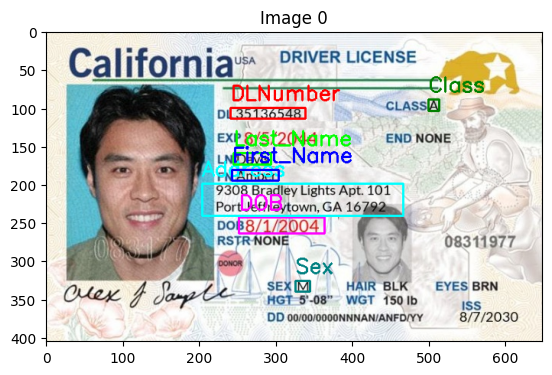

ExpiryDate: 26/12/2008
First_Name: Donald Marshall
DLNumber: 360423106244
Address: 8 79882 Leonard Orchard Suite 832 ~
Lake Stephaniestad, TX 59856
Last_Name: Jirnices Gilmore
DOB: 2/9/1952
IssueDate: | 26/9/1983)
Sex: iM
Class: 


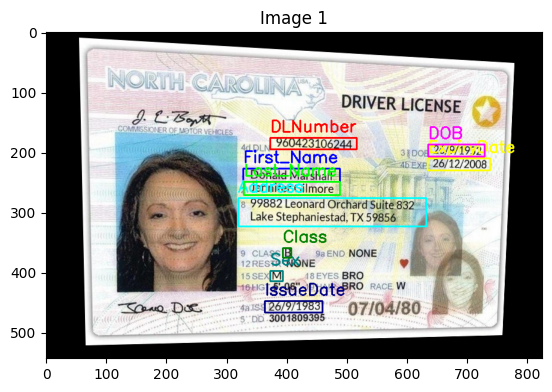

ExpiryDate: 14-11-7032
Name: James Young
Sex: F
DOB: » 14-08-2000
IssueDate: Pear Ediky sé
Address: | 8845 Oak St, Springfield, FL 20132
DLNumber: ) 060819 262 633 |


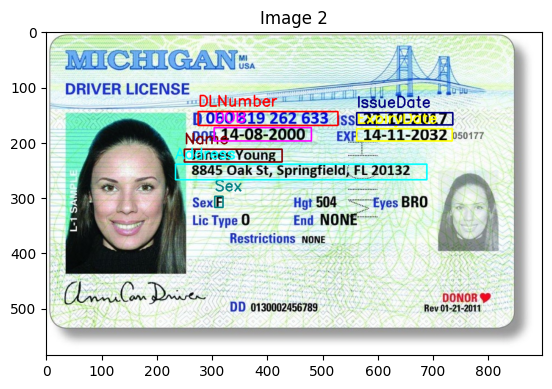

DOB: 08-07-1962
IssueDate: i 16-05-2022
ExpiryDate: :06-10-2026
Sex: M
Address: 7960:PINE ST, FRANKLIN, CA:.75396
Class: A
DLNumber: | AQ? 355 501 794
Name: PT ISA-HART


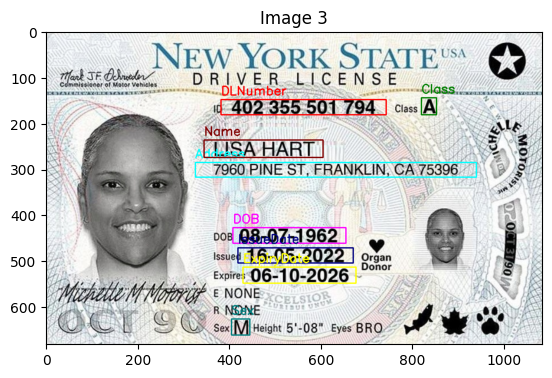

In [17]:
import random
import pytesseract
import cv2
import matplotlib.pyplot as plt

# Function to preprocess image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# List of sample images
image_paths = [
    '/content/drive/MyDrive/dataset_us/val/images/cal109.jpg',
    '/content/drive/MyDrive/dataset_us/val/images/caro109.jpg',
    '/content/drive/MyDrive/dataset_us/val/images/michi_105.jpg',
    '/content/drive/MyDrive/dataset_us/val/images/ny_106.jpg'
]

# Run detection on sample images
results = model(image_paths)

# Define margin percentage (e.g., 5%)
margin_percent = 0.07

# List of colors for different fields
colors = [
    (255, 0, 0),  # Red
    (0, 255, 0),  # Green
    (0, 0, 255),  # Blue
    (255, 255, 0),  # Cyan
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Yellow
    (128, 0, 0),  # Maroon
    (128, 128, 0),  # Olive
    (0, 128, 0),  # Dark Green
    (0, 0, 128),  # Navy
    (128, 0, 128),  # Purple
    (0, 128, 128)  # Teal
]

for i, result in enumerate(results):
    # Load the original image
    image = cv2.imread(image_paths[i])

    # Extract the Boxes object
    boxes_obj = result.boxes

    if boxes_obj is not None:
        # Extract bounding boxes and class IDs
        boxes = boxes_obj.xyxy.cpu().numpy()  # Bounding box coordinates
        class_ids = boxes_obj.cls.cpu().numpy().astype(int)  # Class IDs
        labels = [result.names[int(cls)] for cls in class_ids]

        # Extend colors if there are more labels than colors
        if len(labels) > len(colors):
            for _ in range(len(labels) - len(colors)):
                colors.append(tuple(random.randint(0, 255) for _ in range(3)))

        # Draw bounding boxes
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box[:4]

            # Calculate margin
            margin_x = (x2 - x1) * margin_percent
            margin_y = (y2 - y1) * margin_percent

            # Expand the bounding box by the margin
            x1 = max(0, x1 - margin_x)
            y1 = max(0, y1 - margin_y)
            x2 = min(image.shape[1], x2 + margin_x)
            y2 = min(image.shape[0], y2 + margin_y)

            # Select color for the current label
            color = colors[class_ids[labels.index(label)] % len(colors)]

            # Draw the expanded bounding box
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            # Crop the detected field with margin
            cropped_img = image[int(y1):int(y2), int(x1):int(x2)]
            preprocessed_img = preprocess_image(cropped_img)

            if label in ["Name", "Address"]:
                # Use Tesseract OCR to read text from the cropped field
                text_eng = pytesseract.image_to_string(cropped_img, config='--psm 6', lang='eng').strip()
                text = text_eng
            else:
                text = pytesseract.image_to_string(cropped_img, config='--psm 6', lang='eng').strip()

             # Print the extracted text
            print(f'{label}: {text}')

    else:
        print(f"No detections in image {i}")

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i}")
    plt.show()
